In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from deap import base, creator, tools, algorithms

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)   

data = pd.read_csv('DATA_KOTA.csv')
data_kecelakaan = data['jumlah_kecelakaan']
X = data_kecelakaan[:-1].values.reshape(-1,1)
y = data_kecelakaan[1:].values.reshape(-1,1).ravel()

df = pd.DataFrame(data)

# Pastikan jumlah sampel dan target sama
assert len(X) == len(y), "Jumlah sampel dan target harus sama"

# Membagi kolom tanggal menjadi tahun dan bulan
df['tahun'] = df['tahun_bulan'].apply(lambda x: int(x.split('-')[0]))
df['bulan'] = df['tahun_bulan'].apply(lambda x: int(x.split('-')[1]))

# Normalisasi MinMax
scaler = MinMaxScaler()
df['jumlah_kecelakaan'] = scaler.fit_transform(df[['jumlah_kecelakaan']])

# Memisahkan fitur dan target
X = df[['tahun', 'bulan']].values
y = df['jumlah_kecelakaan'].values

In [3]:
# Pisahkan data menjadi training dan testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [4]:
# Fungsi untuk menghitung MAPE menggunakan model SVR dengan parameter tertentu
def calculate_mape(X_train, y_train, X_val, y_val, params):
    C, epsilon, gamma = params
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, y_pred) * 100
    return mape

# Inisialisasi populasi awal
def initialize_population(population_size, parameter_ranges):
    population = []
    for _ in range(population_size):
        chromosome = []
        for param_range in parameter_ranges:
            param_value = np.random.uniform(param_range[0], param_range[1])
            chromosome.append(param_value)
        population.append(chromosome)
    return population

# Seleksi individu berdasarkan nilai fitness (MAPE)
def selection(population, X_train, y_train, X_val, y_val):
    selected_population = []
    for chromosome in population:
        mape = calculate_mape(X_train, y_train, X_val, y_val, chromosome)
        selected_population.append((chromosome, mape))
    selected_population.sort(key=lambda x: x[1])  # Sort berdasarkan MAPE terendah
    return selected_population[:len(population)//2]  # Pilih setengah individu terbaik
    
# Crossover: Menghasilkan keturunan dari pasangan individu terpilih
def crossover(selected_population):
    new_population = []
    ukuran_populasi = len(selected_population)
    
    for i in range(ukuran_populasi):
        parent1 = selected_population[i][0]
        
        # Tentukan parent2 dengan pemeriksaan batas
        if i % 2 == 0:
            if i - 1 >= 0:
                parent2 = selected_population[i-1][0]
            else:
                parent2 = selected_population[i][0]  # Penanganan alternatif jika i-1 tidak valid
        else:
            if i + 1 < ukuran_populasi:
                parent2 = selected_population[i+1][0]
            else:
                parent2 = selected_population[i][0]  # Penanganan alternatif jika i+1 tidak valid
        
        crossover_point = np.random.randint(1, len(parent1)-1)
        child = parent1[:crossover_point] + parent2[crossover_point:]
        new_population.append(child)
    
    return new_population

# Mutasi: Mengubah nilai gen secara acak pada populasi baru
def mutation(new_population, mutation_rate, parameter_ranges):
    for i in range(len(new_population)):
        if np.random.random() < mutation_rate:
            mutated_gene_index = np.random.randint(0, len(new_population[i]))
            new_value = np.random.uniform(parameter_ranges[mutated_gene_index][0], parameter_ranges[mutated_gene_index][1])
            new_population[i][mutated_gene_index] = new_value
    return new_population

In [5]:
# Rentang nilai sigma yang akan diuji
sigma_ranges = [(0.001, 0.01), (0.001, 0.1), (0.005, 0.01), (0.005, 0.1), (0.01, 0.1), (0.01, 1), (0.05,0.1), (0.05, 1), (0.1, 1), (0.1, 5), (0.5, 1), (0.5, 5)]
crossover_rate = 1  # Tetapkan tingkat crossover tetap untuk eksperimen
mutation_rate = 0  # Tetapkan tingkat mutasi tetap untuk eksperimen
num_generations = 250  # Tetapkan jumlah generasi tetap untuk eksperimen
parameter_ranges = [(0.0001, 50), (1e-07, 5), (1e-07, 5)]

results = []

# Evaluasi kombinasi sigma yang diminta
for sigma_range in sigma_ranges:
    parameter_ranges = [(sigma_range[0], 50), (1e-07, 5), (1e-07, 5)]
    population_size = 70  # Ukuran populasi tetap

    population = initialize_population(population_size, parameter_ranges)

    for generation in range(num_generations):
        selected_population = selection(population, X_train, y_train, X_val, y_val)
        new_population = crossover(selected_population)
        new_population = mutation(new_population, mutation_rate, parameter_ranges)

        # Pastikan ukuran populasi tetap
        if len(new_population) < population_size:
            additional_individuals = initialize_population(population_size - len(new_population), parameter_ranges)
            new_population.extend(additional_individuals)
        elif len(new_population) > population_size:
            new_population = new_population[:population_size]

        assert len(new_population) == population_size, "Ukuran populasi baru tidak sesuai"

        population = new_population

    # Ambil individu terbaik (dengan MAPE terendah) dari populasi terakhir
    best_chromosome, best_population_mape = min(selected_population, key=lambda x: x[1])
    results.append((sigma_range, best_population_mape))

    print(f"MAPE terbaik untuk rentang sigma {sigma_range}: {best_population_mape}")

# Tampilkan hasil terbaik
best_result = min(results, key=lambda x: x[1])
print(f"\nKombinasi sigma terbaik:")
print(f"Rentang sigma: {best_result[0]}")
print(f"MAPE terbaik: {best_result[1]}")

MAPE terbaik untuk rentang sigma (0.001, 0.01): 30.068821569195254
MAPE terbaik untuk rentang sigma (0.001, 0.1): 27.832971116184442
MAPE terbaik untuk rentang sigma (0.005, 0.01): 26.67891392700586
MAPE terbaik untuk rentang sigma (0.005, 0.1): 29.937324327839672
MAPE terbaik untuk rentang sigma (0.01, 0.1): 26.897973424587267
MAPE terbaik untuk rentang sigma (0.01, 1): 27.787458615952236
MAPE terbaik untuk rentang sigma (0.05, 0.1): 28.67244534772444
MAPE terbaik untuk rentang sigma (0.05, 1): 29.21606652911403
MAPE terbaik untuk rentang sigma (0.1, 1): 30.07840079975522
MAPE terbaik untuk rentang sigma (0.1, 5): 26.773319051221268
MAPE terbaik untuk rentang sigma (0.5, 1): 27.4978755207751
MAPE terbaik untuk rentang sigma (0.5, 5): 27.962347227717387

Kombinasi sigma terbaik:
Rentang sigma: (0.005, 0.01)
MAPE terbaik: 26.67891392700586


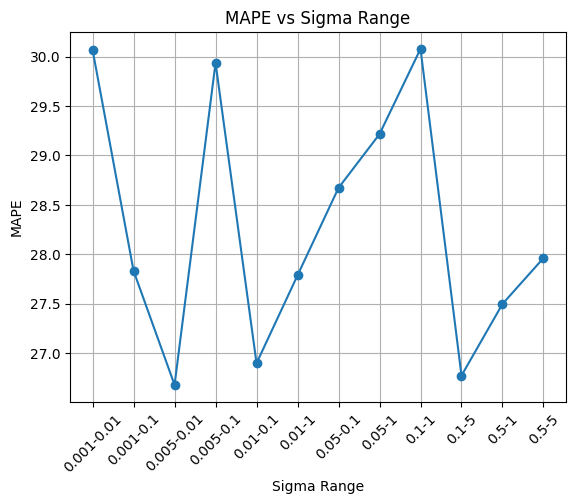

In [6]:
# Plot hasil
fig, ax = plt.subplots()
sigma_ranges_str = [f"{r[0]}-{r[1]}" for r in sigma_ranges]
mapes = [r[1] for r in results]
ax.plot(sigma_ranges_str, mapes, marker='o')
ax.set_xlabel('Sigma Range')
ax.set_ylabel('MAPE')
ax.set_title('MAPE vs Sigma Range')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [5]:
# Rentang nilai sigma yang akan diuji
sigma_ranges = [(0.001, 0.01), (0.001, 0.1), (0.005, 0.01), (0.005, 0.1), (0.01, 0.1), (0.01, 1), (0.05,0.1), (0.05, 1), (0.1, 1), (0.1, 5), (0.5, 1), (0.5, 5)]
crossover_rate = 0.4  # Tetapkan tingkat crossover tetap untuk eksperimen
mutation_rate = 0.4  # Tetapkan tingkat mutasi tetap untuk eksperimen
generations = 75  # Tetapkan jumlah generasi tetap untuk eksperimen
population_size = 100  # Tetapkan ukuran populasi tetap untuk eksperimen

results = []

for sigma_range in sigma_ranges:
    sigma_start, sigma_end = sigma_range
    #sigma = random.uniform(sigma_start, sigma_end)
    
    toolbox.unregister("mutate")
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=sigma_range, indpb=0.1)
    population = toolbox.population(n=population_size)
        
    for gen in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population[:] = toolbox.select(offspring, k=len(population))

    # Jalankan algoritma evolusi dengan rentang sigma tertentu
    best_ind = tools.selBest(population, 1)[0]
    best_mape = best_ind.fitness.values[0]
    best_gamma = best_ind[0]
    best_C = best_ind[1]
    best_epsilon = best_ind[2]
    best_model = SVR(gamma=best_gamma, C=best_C, epsilon=best_epsilon)
    best_model.fit(X_train, y_train)
    best_predictions = best_model.predict(X_test)
    best_mape = mean_absolute_percentage_error(y_test, best_predictions)
    results.append((sigma_range, best_mape))
    print(f"Sigma range: {sigma_range}, Best gamma : {best_gamma}, Best C : {best_C}, Best epsilon : {best_epsilon}, MAPE: {best_mape}")

IndexError: sigma must be at least the size of individual: 2 < 3

In [5]:
# Rentang nilai sigma yang akan diuji
sigma_ranges = [(0.001, 0.01), (0.001, 0.1), (0.005, 0.01), (0.005, 0.1), (0.01, 0.1), (0.01, 1), (0.05,0.1), (0.05, 1), (0.1, 1), (0.1, 5), (0.5, 1), (0.5, 5)]
crossover_rate = 0.4  # Tetapkan tingkat crossover tetap untuk eksperimen
mutation_rate = 0.4  # Tetapkan tingkat mutasi tetap untuk eksperimen
generations = 75  # Tetapkan jumlah generasi tetap untuk eksperimen
population_size = 100  # Tetapkan ukuran populasi tetap untuk eksperimen

results = []

for sigma_range in sigma_ranges:
    population = toolbox.population(n=population_size)
    
    # Algoritma evolusi kustom untuk menyertakan sigma dalam mutasi
    def ea_with_sigma(population, toolbox, cxpb, mutpb, ngen, sigma_range, stats=None, halloffame=None, verbose=__debug__):
        logbook = tools.Logbook()
        logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
        
        invalid_ind = [ind for ind in population if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        if halloffame is not None:
            halloffame.update(population)
        record = stats.compile(population) if stats else {}
        logbook.record(gen=0, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        
        for gen in range(1, ngen + 1):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            for mutant in offspring:
                if np.random.random() < mutpb:
                    toolbox.mutate(mutant, sigma_range=sigma_range)
                    del mutant.fitness.values
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            if halloffame is not None:
                halloffame.update(offspring)
            population[:] = offspring
            record = stats.compile(population) if stats else {}
            logbook.record(gen=gen, nevals=len(invalid_ind), **record)
            if verbose:
                print(logbook.stream)
        return population, logbook

    # Jalankan algoritma evolusi dengan rentang sigma tertentu
    ea_with_sigma(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate, ngen=generations, sigma_range=sigma_range, verbose=False)
    best_individual = tools.selBest(population, 1)[0]
    best_C = best_individual[0]
    best_model = SVR(C=best_C)
    best_model.fit(X_train, y_train)
    best_predictions = best_model.predict(X_test)
    best_mape = mean_absolute_percentage_error(y_test, best_predictions)
    results.append((sigma_range, best_mape))
    print(f"Sigma range: {sigma_range}, Best parameter C: {best_C}, MAPE: {best_mape}")

TypeError: custom_mutate() got an unexpected keyword argument 'sigma_range'

In [6]:
#population = toolbox.population(n=50)
#ngen = 10
#cxpb = 0.6
#mutpb = 0.1
#hof = tools.HallOfFame(1)
#stats = tools.Statistics(lambda ind: ind.fitness.values)
#stats.register("avg", np.mean)
#stats.register("min", np.min)
#stats.register("max", np.max)

pop_size = 50
generation = 40
cross_prob = 0.5
mut_prob = 0.1

pop = toolbox.population(n=pop_size)

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

for _ in range (generation):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=cross_prob, mutpb=mut_prob)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    pop = toolbox.select(offspring, k=len(pop))

best_individual = tools.selBest(pop, k=1)[0]
best_C = best_individual[0]
print(f"Best Parameter C:{best_C}")

# Jalankan algoritma genetika
#population, logbook = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats, halloffame=hof, verbose=True)

# Ambil hasil terbaik
#best_individual = tools.selBest(population, k=1)[0]
#print('Best Individual: ', best_individual)

InvalidParameterError: The 'C' parameter of SVR must be a float in the range (0.0, inf). Got -112.14608452764202 instead.

In [ ]:
best_model = SVR(C=best_C)
best_model.fit(X_train, y_train)
best_pred = best_model.predict(X_test)

In [ ]:
best_mape = mean_absolute_percentage_error(y_test, best_pred)
print(f"MAPE terbaik : {best_mape}")

In [7]:
print(mape)

0.9028127644582353


In [8]:
print('Best Individual: ', best_individual)
print("best C:", 10 ** best_individual[0])

Best Individual:  [0.2527526002996481]
best C: 1.789586110022803


In [10]:
C_best = 10 ** best_individual[0]
svr_best = SVR(C=C_best)
svr_best.fit(X_train, y_train)
y_pred_best = svr_best.predict(X_test)
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
print(mape_best)

0.9466256155159226


In [12]:
#svr = SVR(kernel='rbf', C=C, epsilon=epsilon, gamma=gamma)
#svr.fit(X_train, y_train)
#y_pred = svr.predict(X_test)

best_C = 10 ** best_individual[0]
best_epsilon = 10 ** best_individual[1]
best_gamma = 10 ** best_individual[2]
svr_best_model = SVR(kernel='rbf', C=best_C, epsilon=best_epsilon, gamma=best_gamma)

# Training model
svr_best_model.fit(X_train, y_train)

# Prediksi
y_pred_best = svr_best_model.predict(X_test)
print(y_pred_best)
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
#mape = np.mean(np.abs((y_test-svr_best_model.predict(X_test))/y_test))*100
#print(mape)
print(mape_best)

[29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
1.6365199071081422


In [7]:








# Model SVR dengan hyperparameter terbaik
best_C, best_epsilon = best_individual
svr_best_model = SVR(C=best_C, epsilon=best_epsilon)

# Training model
svr_best_model.fit(X_train, y_train)

# Prediksi
y_pred_best = svr_best_model.predict(X_test)

# Hitung MAPE
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
print(f'Best MAPE: {mape_best}')
print(y_pred_best)

NameError: name 'best_individual' is not defined